<a href="https://colab.research.google.com/github/TAUforPython/ts-forecasting-ensemble/blob/master/timeseries%20SMETS%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis of the SMETS Paper

# **Main Idea of SMETS (Semi-Metric Ensemble Time Series)**

# The paper "A Method for Comparing Multivariate Time Series with Different Dimensions" by Tapinos & Mendes (2013) introduces SMETS to address a key limitation in comparing dynamical systems: existing methods typically require multivariate time series to have the same number of variables (dimensions).

# **The Core Problem:**
# *   We often want to compare complex systems based on their temporal behavior (represented by multivariate time series).
#   *   E.g., Comparing two biochemical models with 3 and 5 variables respectively.
#   *   E.g., Comparing stock portfolios with 30 (Dow Jones) and 100 (NASDAQ) stocks.
# *   Traditional methods either:
#     1.  Are limited to univariate time series.
#     2.  Require multivariate time series to have the same dimensionality.
#     3.  Collapse the multivariate data into a single average time series, losing potentially important information about individual components.

# **SMETS Solution:**
# SMETS is a **semi-metric** designed to calculate a distance between two groups (ensembles) of time series that can have different numbers of components (variables).

# **Key Steps of the SMETS Algorithm:**

# 1.  **Preprocessing (Implicit):**
#     *   Normalize time series (e.g., by mean and standard deviation) to focus on shape.
#     *   Optionally, transform time series into a compressed representation (e.g., Haar DWT) for efficiency and noise reduction.

# 2.  **Part 1: Partial Matching:**
#     *   Identify the time series group with the *smaller* number of components (let's say `n` components) and the one with the *larger* number (`m` components, where `m >= n`).
#     *   Calculate the distance (e.g., Euclidean distance in DWT space) between *every* component of the smaller group and *every* component of the larger group. This creates an `n x m` distance matrix.
#     *   Find the pair of components (one from each group) with the smallest distance.
#     *   Record this smallest distance and remove both matched components from further consideration.
#     *   Repeat the matching process until *all* components from the smaller group have been matched to a unique component in the larger group.
#     *   You now have a vector `d` containing `n` distances corresponding to the `n` best matches.
#     *   Calculate the overall similarity of these matched pairs using a p-norm (specifically, the `n`-norm) of the vector `d`. This gives a single value `||d||_n` representing the core similarity.

# 3.  **Part 2: Penalization:**
#     *   Since not all components in the larger group were matched, there's potentially unmatched information contributing to dissimilarity.
#     *   **Penalty 1 (Entropy Penalty - EP):**
#         *   For each of the `m-n` unmatched components in the larger group, find its smallest distance `d_j` to *any* component in the *smaller* group.
#         *   Calculate the **Shannon entropy** `H_j` of the unmatched time series component `j`. This measures the information content (variability) of that component. A constant trace has zero entropy.
#         *   Compute the **relative information content** `RE_j` for the unmatched component `j` as: `RE_j = (min_d_j * H_j) / (sum of entropies of ALL components in the larger group)`.
#         *   The first penalty `EP` is the sum of `RE_j` for all `m-n` unmatched components. Components with high information content (`H_j`) and large minimum distances (`d_j`) contribute more to this penalty.
#     *   **Penalty 2 (Cardinality Penalty - P):**
#         *   This penalty accounts for the sheer *difference* in the number of components between the two groups.
#         *   It is calculated as: `P = (m - n) / (m + n)`. This ratio increases as the dimensionalities become more different.
#     *   **Final Distance Calculation:**
#         *   The final SMETS distance combines the matched similarity (`||d||_n`) and the two penalties (`EP`, `P`) using a 2-norm (Euclidean distance):
#           `SMETS = sqrt( (||d||_n + EP)^2 + P^2 )`
#         *   This ensures the final distance is sensitive to both the quality of matching and the structural differences (unmatched components, dimensionality gap).

# **Why is SMETS a Semi-Metric?**
# *   It satisfies **Non-negativity**, **Symmetry**, and **Reflexivity** (distance is zero only if the two groups are identical).
# *   It generally **does *not* satisfy the Triangle Inequality** due to the partial matching step. Therefore, it's a **semi-metric**, which is still suitable for tasks like clustering and classification.

# **Advantages Highlighted:**
# *   **Handles Different Dimensions:** Directly compares time series groups of any size.
#   *   **Uses All Information:** Unlike averaging, it considers the behavior of each individual component and penalizes unmatched ones.
#   *   **Incorporates Information Content:** The entropy-based penalty weights unmatched components by their variability.

# ---

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler
import itertools

In [1]:
def haar_dwt_simple(signal, level=1):
    """
    A simple Haar Discrete Wavelet Transform implementation for demonstration.
    Keeps only the approximation coefficients at the specified level.
    Assumes signal length is a power of 2.
    """
    if len(signal) <= 1 or level <= 0:
        return signal

    # Haar transform step
    approx = (signal[0::2] + signal[1::2]) / np.sqrt(2)
    # detail = (signal[0::2] - signal[1::2]) / np.sqrt(2) # Not used here

    # Recurse on approximation coefficients
    return haar_dwt_simple(approx, level - 1)

def pad_to_power_of_two(ts, pad_value=0):
    """Pads a time series to the next power of two length."""
    n = len(ts)
    next_pow2 = 1 << (n - 1).bit_length() # Bit twiddling for next power of 2
    if n < next_pow2:
        ts_padded = np.pad(ts, (0, next_pow2 - n), 'constant', constant_values=pad_value)
    else:
        ts_padded = ts
    return ts_padded

def smets(ts_group_a, ts_group_b, use_dwt=True, dwt_level=2, use_entropy=True):
    """
    Calculates the SMETS distance between two groups of time series.

    Args:
        ts_group_a (list of np.array): First group of time series.
        ts_group_b (list of np.array): Second group of time series.
        use_dwt (bool): If True, use Haar DWT for representation.
        dwt_level (int): Level of DWT to apply (approximation level).
        use_entropy (bool): If True, include entropy penalty.

    Returns:
        float: The SMETS distance.
    """
    # Ensure groups are numpy arrays
    ts_group_a = [np.asarray(ts) for ts in ts_group_a]
    ts_group_b = [np.asarray(ts) for ts in ts_group_b]

    # Determine smaller and larger group
    if len(ts_group_a) <= len(ts_group_b):
        smaller_group = ts_group_a
        larger_group = ts_group_b
    else:
        smaller_group = ts_group_b
        larger_group = ts_group_a

    n = len(smaller_group)
    m = len(larger_group)

    # --- Preprocessing ---
    processed_smaller = []
    processed_larger = []
    scaler = StandardScaler()

    # Normalize and optionally transform each time series
    for ts in smaller_group:
        ts_norm = scaler.fit_transform(ts.reshape(-1, 1)).flatten()
        if use_dwt:
            ts_padded = pad_to_power_of_two(ts_norm)
            ts_transformed = haar_dwt_simple(ts_padded, level=dwt_level)
            processed_smaller.append(ts_transformed)
        else:
            processed_smaller.append(ts_norm)

    for ts in larger_group:
        ts_norm = scaler.fit_transform(ts.reshape(-1, 1)).flatten()
        if use_dwt:
            ts_padded = pad_to_power_of_two(ts_norm)
            ts_transformed = haar_dwt_simple(ts_padded, level=dwt_level)
            processed_larger.append(ts_transformed)
        else:
            processed_larger.append(ts_norm)

    # --- Part 1: Partial Matching ---
    # Create distance matrix between smaller and larger groups
    dist_matrix = np.zeros((n, m))
    for i, ts_s in enumerate(processed_smaller):
        for j, ts_l in enumerate(processed_larger):
            # Using Euclidean distance in (DWT) space
            dist_matrix[i, j] = euclidean(ts_s, ts_l)

    # Find minimum cost matching (greedy approach, suitable for this metric structure)
    # This is essentially solving a linear assignment problem for a subset.
    # A simple greedy approach: repeatedly find and remove the global minimum.
    matched_distances = []
    used_indices_larger = set()

    dist_matrix_copy = dist_matrix.copy() # Work on a copy
    for _ in range(n):
        # Find global minimum in the remaining matrix
        min_idx = np.unravel_index(np.argmin(dist_matrix_copy, axis=None), dist_matrix_copy.shape)
        i, j = min_idx
        matched_distances.append(dist_matrix_copy[i, j])

        # Invalidate row i and column j for future matches
        dist_matrix_copy[i, :] = np.inf
        dist_matrix_copy[:, j] = np.inf
        used_indices_larger.add(j) # Track indices used in larger group

    d_vector = np.array(matched_distances)
    # Calculate p-norm where p = dimension of smaller group (n)
    if n > 0:
        # Using the n-th root of the sum of d_i^n
        norm_d = np.power(np.sum(np.power(d_vector, n)), 1.0/n) if n > 0 else 0.0
    else:
        norm_d = 0.0

    # --- Part 2: Penalization ---
    # Identify unmatched components in the larger group
    unmatched_indices = [i for i in range(m) if i not in used_indices_larger]
    num_unmatched = len(unmatched_indices)

    entropy_penalty = 0.0
    cardinality_penalty = 0.0

    if num_unmatched > 0 and use_entropy:
        # --- Penalty 1: Entropy Penalty (EP) ---
        # Calculate entropies for all components in the *original* larger group (before DWT)
        entropies_larger_original = []
        for ts in larger_group: # Use original ts for entropy calc
             # Add small epsilon to avoid log(0)
             ts_counts = np.bincount(np.digitize(ts, bins=np.linspace(ts.min(), ts.max(), 11))) # Discretize for entropy
             ts_probs = ts_counts / len(ts)
             ts_probs = ts_probs[ts_probs > 0] # Remove zero probabilities
             entropies_larger_original.append(entropy(ts_probs, base=2) if len(ts_probs) > 0 else 0)

        total_entropy_larger = np.sum(entropies_larger_original)

        if total_entropy_larger > 0:
            sum_re = 0.0
            for idx in unmatched_indices:
                ts_unmatched_processed = processed_larger[idx]
                # Find minimum distance from this unmatched component to *any* component in the smaller group
                min_dist_to_smaller = np.min([euclidean(ts_unmatched_processed, ts_s_proc) for ts_s_proc in processed_smaller])
                # Get original entropy
                h_j = entropies_larger_original[idx]
                # Calculate RE_j
                re_j = (min_dist_to_smaller * h_j) / total_entropy_larger
                sum_re += re_j
            entropy_penalty = sum_re

    # --- Penalty 2: Cardinality Penalty (P) ---
    if m + n > 0:
        cardinality_penalty = (m - n) / (m + n)

    # --- Final SMETS Distance ---
    # Combine using 2-norm as per the paper
    smets_distance = np.sqrt((norm_d + entropy_penalty)**2 + cardinality_penalty**2)

    return smets_distance


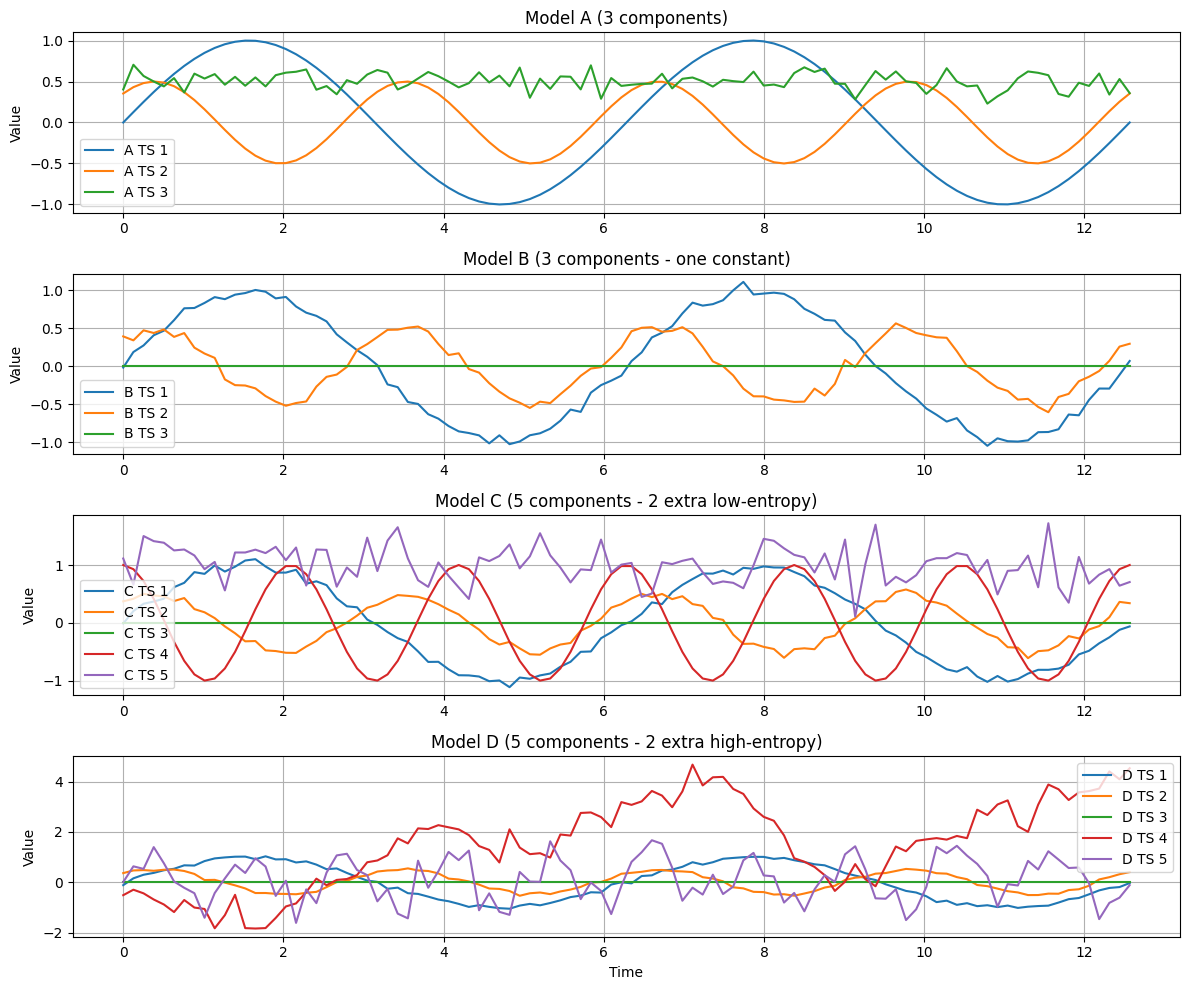

In [4]:


# --- Example: Demonstrating SMETS Advantage ---

# Let's create synthetic time series to show how SMETS can distinguish models
# where simple averaging might fail.

# Time points
t = np.linspace(0, 4*np.pi, 100)

# --- Model A (3 components) ---
# 1. Oscillating component
ts_a1 = np.sin(t)
# 2. Another oscillating component (different frequency)
ts_a2 = 0.5 * np.sin(2*t + np.pi/4)
# 3. A mostly constant component with low variability
ts_a3 = 0.1 * np.random.randn(len(t)) + 0.5 # Low entropy

ts_group_a = [ts_a1, ts_a2, ts_a3]

# --- Model B (3 components) ---
# Similar to A, but one component is constant (zero entropy)
ts_b1 = np.sin(t) + 0.05*np.random.randn(len(t)) # Similar to A1
ts_b2 = 0.5 * np.sin(2*t + np.pi/4) + 0.05*np.random.randn(len(t)) # Similar to A2
ts_b3 = np.zeros_like(t) # Exactly constant, zero entropy

ts_group_b = [ts_b1, ts_b2, ts_b3]

# --- Model C (5 components) ---
# Contains the core behavior of A and B, plus extra unmatched components
ts_c1 = np.sin(t) + 0.05*np.random.randn(len(t)) # Similar to A1/B1
ts_c2 = 0.5 * np.sin(2*t + np.pi/4) + 0.05*np.random.randn(len(t)) # Similar to A2/B2
ts_c3 = np.zeros_like(t) # Similar to B3
# Extra unmatched components
ts_c4 = np.cos(3*t) # Different oscillation
ts_c5 = 0.3 * np.random.randn(len(t)) + 1.0 # Different constant level, low entropy

ts_group_c = [ts_c1, ts_c2, ts_c3, ts_c4, ts_c5]

# --- Model D (5 components) ---
# Also similar core, but extra components have high variability (high entropy)
ts_d1 = np.sin(t) + 0.05*np.random.randn(len(t)) # Similar to A1/B1/C1
ts_d2 = 0.5 * np.sin(2*t + np.pi/4) + 0.05*np.random.randn(len(t)) # Similar to A2/B2/C2
ts_d3 = np.zeros_like(t) # Similar to B3/C3
# Extra unmatched components with high entropy
ts_d4 = np.cumsum(np.random.randn(len(t)) * 0.5) # Random walk - high entropy
ts_d5 = np.sin(5*t) + 0.5*np.random.randn(len(t)) # High frequency oscillation + noise - high entropy

ts_group_d = [ts_d1, ts_d2, ts_d3, ts_d4, ts_d5]

# --- Visualization ---
plt.figure(figsize=(12, 10))

# Plot Model A
plt.subplot(4, 1, 1)
for i, ts in enumerate(ts_group_a):
    plt.plot(t, ts, label=f'A TS {i+1}')
plt.title('Model A (3 components)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot Model B
plt.subplot(4, 1, 2)
for i, ts in enumerate(ts_group_b):
    plt.plot(t, ts, label=f'B TS {i+1}')
plt.title('Model B (3 components - one constant)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot Model C
plt.subplot(4, 1, 3)
for i, ts in enumerate(ts_group_c):
    plt.plot(t, ts, label=f'C TS {i+1}')
plt.title('Model C (5 components - 2 extra low-entropy)')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Plot Model D
plt.subplot(4, 1, 4)
for i, ts in enumerate(ts_group_d):
    plt.plot(t, ts, label=f'D TS {i+1}')
plt.title('Model D (5 components - 2 extra high-entropy)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

--- Calculating Distances ---

--- Distances using Averaged Time Series (Euclidean) ---
Dist(Avg A, Avg B): 1.7008
Dist(Avg A, Avg C): 1.9183
Dist(Avg A, Avg D): 4.6230
Dist(Avg B, Avg C): 2.7297
Dist(Avg B, Avg D): 5.3439
Dist(Avg C, Avg D): 4.4646

--- Distances using SMETS ---
SMETS(A, B): 5.2575
SMETS(A, C): 9.1902
SMETS(A, D): 10.6428
SMETS(B, C): 4.5640
SMETS(B, D): 5.1239
SMETS(C, D): 13.5539

--- Analysis ---
Models A and B have the same core structure (two oscillators, one constant/low-var).
Model C adds two extra low-entropy components to the A/B core.
Model D adds two extra high-entropy components to the A/B core.

Observations:
1. Average Distance (Avg A, Avg B) vs (Avg A, Avg C):
   - Distance A-B: 1.7008
   - Distance A-C: 1.9183
   -> Averages might be similar if the extra low-var components don't shift the mean much.

2. SMETS Distance (SMETS A, B) vs (SMETS A, C):
   - SMETS A-B: 5.2575
   - SMETS A-C: 9.1902
   -> SMETS correctly identifies A and B as more similar, pe

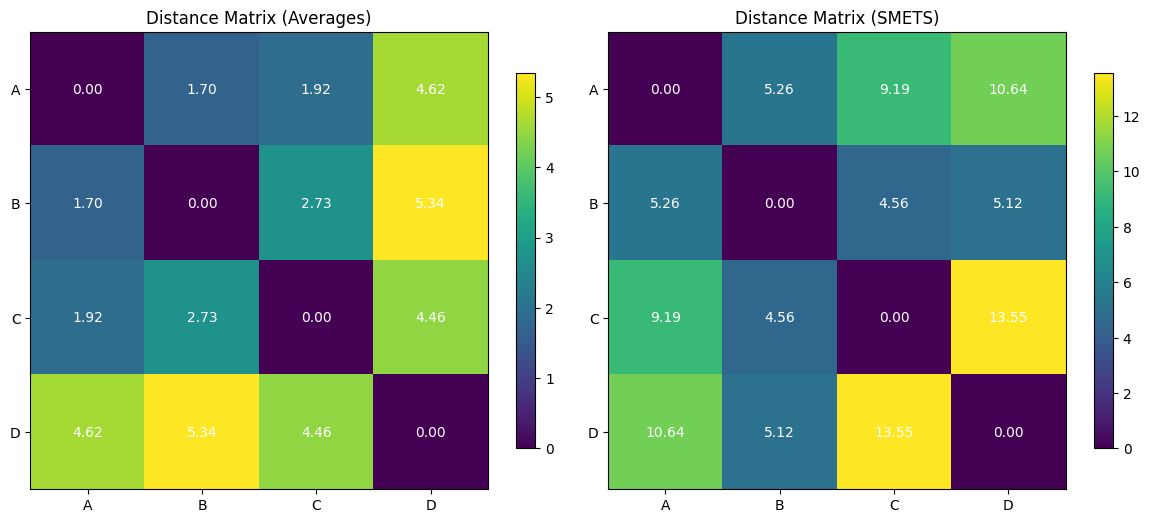


--- Conclusion ---
This example illustrates the core advantage of SMETS:
1. It considers the structure and individual components of multivariate time series.
2. It penalizes for unmatched components, especially those with high information content (entropy).
3. It can potentially provide a more nuanced similarity measure than simple averaging,
   which can obscure differences in the underlying component dynamics.


In [5]:


print("--- Calculating Distances ---")

# 1. Simple Euclidean distance between averages (Traditional method)
avg_a = np.mean(ts_group_a, axis=0)
avg_b = np.mean(ts_group_b, axis=0)
avg_c = np.mean(ts_group_c, axis=0)
avg_d = np.mean(ts_group_d, axis=0)

dist_avg_ab = euclidean(avg_a, avg_b)
dist_avg_ac = euclidean(avg_a, avg_c)
dist_avg_ad = euclidean(avg_a, avg_d)
dist_avg_bc = euclidean(avg_b, avg_c)
dist_avg_bd = euclidean(avg_b, avg_d)
dist_avg_cd = euclidean(avg_c, avg_d)

print("\n--- Distances using Averaged Time Series (Euclidean) ---")
print(f"Dist(Avg A, Avg B): {dist_avg_ab:.4f}")
print(f"Dist(Avg A, Avg C): {dist_avg_ac:.4f}")
print(f"Dist(Avg A, Avg D): {dist_avg_ad:.4f}")
print(f"Dist(Avg B, Avg C): {dist_avg_bc:.4f}")
print(f"Dist(Avg B, Avg D): {dist_avg_bd:.4f}")
print(f"Dist(Avg C, Avg D): {dist_avg_cd:.4f}")

# 2. SMETS distances
dist_smets_ab = smets(ts_group_a, ts_group_b, use_dwt=True, dwt_level=2, use_entropy=True)
dist_smets_ac = smets(ts_group_a, ts_group_c, use_dwt=True, dwt_level=2, use_entropy=True)
dist_smets_ad = smets(ts_group_a, ts_group_d, use_dwt=True, dwt_level=2, use_entropy=True)
dist_smets_bc = smets(ts_group_b, ts_group_c, use_dwt=True, dwt_level=2, use_entropy=True)
dist_smets_bd = smets(ts_group_b, ts_group_d, use_dwt=True, dwt_level=2, use_entropy=True)
dist_smets_cd = smets(ts_group_c, ts_group_d, use_dwt=True, dwt_level=2, use_entropy=True)

print("\n--- Distances using SMETS ---")
print(f"SMETS(A, B): {dist_smets_ab:.4f}")
print(f"SMETS(A, C): {dist_smets_ac:.4f}")
print(f"SMETS(A, D): {dist_smets_ad:.4f}")
print(f"SMETS(B, C): {dist_smets_bc:.4f}")
print(f"SMETS(B, D): {dist_smets_bd:.4f}")
print(f"SMETS(C, D): {dist_smets_cd:.4f}")

# --- Comparison / Analysis of Results ---
print("\n--- Analysis ---")
print("Models A and B have the same core structure (two oscillators, one constant/low-var).")
print("Model C adds two extra low-entropy components to the A/B core.")
print("Model D adds two extra high-entropy components to the A/B core.")
print("\nObservations:")
print("1. Average Distance (Avg A, Avg B) vs (Avg A, Avg C):")
print(f"   - Distance A-B: {dist_avg_ab:.4f}")
print(f"   - Distance A-C: {dist_avg_ac:.4f}")
print("   -> Averages might be similar if the extra low-var components don't shift the mean much.")

print("\n2. SMETS Distance (SMETS A, B) vs (SMETS A, C):")
print(f"   - SMETS A-B: {dist_smets_ab:.4f}")
print(f"   - SMETS A-C: {dist_smets_ac:.4f}")
if dist_smets_ac > dist_smets_ab:
    print("   -> SMETS correctly identifies A and B as more similar, penalizing C for unmatched components.")
else:
    print("   -> SMETS result might be less clear here if matching dominates.")

print("\n3. SMETS Distance (SMETS A, C) vs (SMETS A, D):")
print(f"   - SMETS A-C: {dist_smets_ac:.4f}")
print(f"   - SMETS A-D: {dist_smets_ad:.4f}")
if dist_smets_ad > dist_smets_ac:
    print("   -> SMETS correctly penalizes D more heavily due to its high-entropy unmatched components.")
else:
    print("   -> Unexpected SMETS result regarding entropy penalty.")

print("\n4. SMETS Distance (SMETS C, D):")
print(f"   - SMETS C-D: {dist_smets_cd:.4f}")
print("   - Both C and D share the A/B core. SMETS should recognize this core similarity.")
print("   - The distance will reflect the difference in their unmatched components (low vs high entropy).")

# --- Visualization of Distance Matrices (Conceptual) ---
# For a more visual comparison, we can create a distance matrix plot.

# Prepare data for plotting
labels = ['A', 'B', 'C', 'D']
avg_distances = np.array([
    [0, dist_avg_ab, dist_avg_ac, dist_avg_ad],
    [dist_avg_ab, 0, dist_avg_bc, dist_avg_bd],
    [dist_avg_ac, dist_avg_bc, 0, dist_avg_cd],
    [dist_avg_ad, dist_avg_bd, dist_avg_cd, 0]
])
smets_distances = np.array([
    [0, dist_smets_ab, dist_smets_ac, dist_smets_ad],
    [dist_smets_ab, 0, dist_smets_bc, dist_smets_bd],
    [dist_smets_ac, dist_smets_bc, 0, dist_smets_cd],
    [dist_smets_ad, dist_smets_bd, dist_smets_cd, 0]
])

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Average Distances
im1 = axes[0].imshow(avg_distances, cmap='viridis', interpolation='nearest')
axes[0].set_title('Distance Matrix (Averages)')
axes[0].set_xticks(range(len(labels)))
axes[0].set_yticks(range(len(labels)))
axes[0].set_xticklabels(labels)
axes[0].set_yticklabels(labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        text = axes[0].text(j, i, f'{avg_distances[i, j]:.2f}',
                           ha="center", va="center", color="w")
fig.colorbar(im1, ax=axes[0], shrink=0.8)

# Plot SMETS Distances
im2 = axes[1].imshow(smets_distances, cmap='viridis', interpolation='nearest')
axes[1].set_title('Distance Matrix (SMETS)')
axes[1].set_xticks(range(len(labels)))
axes[1].set_yticks(range(len(labels)))
axes[1].set_xticklabels(labels)
axes[1].set_yticklabels(labels)
for i in range(len(labels)):
    for j in range(len(labels)):
        text = axes[1].text(j, i, f'{smets_distances[i, j]:.2f}',
                           ha="center", va="center", color="w")
fig.colorbar(im2, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

# --- Conclusion ---
print("\n--- Conclusion ---")
print("This example illustrates the core advantage of SMETS:")
print("1. It considers the structure and individual components of multivariate time series.")
print("2. It penalizes for unmatched components, especially those with high information content (entropy).")
print("3. It can potentially provide a more nuanced similarity measure than simple averaging,")
print("   which can obscure differences in the underlying component dynamics.")
